# 🧀 GD-P 2. 멋진 단어사전 만들기 

* 이번 시간엔 konlpy macab을 이용해 'korean-english-park.train.ko' 데이터셋의 문장길이를 알아보고, 그에 대한 전처리, 형태소 기반 토큰화 작업을 진행 해 보았습니다. 


* 이번 프로젝트에선 SentencePiece 모델을 적용해서 학습을 진행해 보고, 더 나아가 네이버 데이터셋에 SentencePiece 를 적용해 보겠습니다. 




\\
#  루브릭 평가 기준 


| 평가문항 | 상세기준 |
| :---: | :---: |
| 1. SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가? | 코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가? |
| 2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가? | SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다. |
| 3. SentencePiece의 성능을 다각도로 비교분석하였는가? | SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였다. |





\\


---



In [1]:
# 마운트 해제
!fusermount -u drive
!google-drive-ocamlfuse drive


/bin/bash: google-drive-ocamlfuse: command not found


In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
# MeCab 형태소 분석기, konlpy 도 함께 설치! 

!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

--2022-03-23 08:55:36--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2022-03-23 08:55:37--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc14990608dae7eba2aef3999750.dl.dropboxusercontent.com/cd/0/get/Bh8zrsBrmRhAsca8izRekqz0ctYyVOFLzuiRhPLiBK_OEEoj6B2W70law8YXP77UysidutmL1MOaBYhxSjAz2tKSVXEzRPkLftNQBhN6jLBtPVzLOLJZJhazjbM4ELkaq4jXQWkivO8ianwP_nsllB-gljXEWb0Ujf8wD9baJmnpOLMp4--fIZ8BU0gaDk-AFbU/file?dl=1# [following]
--2022-03-23 08:55:37--  https://uc14990608dae7eba2aef3999750.dl.dropboxusercontent.com/cd/0/get/

In [4]:
from konlpy.tag import Mecab

mecab = Mecab()
print(mecab.morphs('자연어처리가너무재밌어서밥먹는것도가끔까먹어요오그렇군요'))

['자연어', '처리', '가', '너무', '재밌', '어서', '밥', '먹', '는', '것', '도', '가끔', '까먹', '어요오', '그렇', '군요']


# SentencePiece 설치하기 


* 이번 프로젝트에 사용할 Sentencepiece 를 설치합니다. 
- SentencePiece는 Google에서 제공하는 오픈소스 기반 Sentence Tokenizer/Detokenizer 로서, BPE와 unigram 2가지 subword 토크나이징 모델 중 하나를 선택해서 사용할 수 있도록 패키징한 것입니다. 
- [링크](https://github.com/google/sentencepiece) 의 페이지에서 상세한 내용을 파악할 수 있습니다. 
- 최근 사전학습된 모델들이 거의 SentencePiece를 tokenizer로 채용하면서, 사실상 표준의 역할을 하고있음. 

In [5]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 7.8 MB/s 


\


# 2-2 데이터 다운로드 및 분석 


1. 먼저 프로젝트에 사용될 라이브러리를 불러옵니다.


In [53]:
import os,re
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tarfile
%matplotlib inline

# 프로젝트 진행 시 추가된 내용 
import sentencepiece as spm
import urllib.request

In [7]:
# !wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz

In [8]:
# $ wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
# $ mkdir -p ~/aiffel/sp_tokenizer/data

In [9]:
# 우선 위치를 확인 해 보고 (드라이브상에서 폴더를 만들고 저장해 줬음.)
os.getcwd()

'/content'

In [10]:
# 이동! 
os.chdir('/content/gdrive/MyDrive/AIFFEL/mkdir/sp_tokenizer/data')

In [11]:
# 압축 해제! 
!tar -xzvf korean-english-park.train.tar.gz

korean-english-park.train.en
korean-english-park.train.ko


In [12]:
# 데이터 파일을 불러와 확인 해 볼까요? 
path_to_file = '/content/gdrive/MyDrive/AIFFEL/mkdir/sp_tokenizer/data/korean-english-park.train.ko'

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))

print("Example:")
for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


- 데이터 개수는 94123개!
- 각 문장이 어느 정도의 길이를 가지는지 확인 해 봅니다.
    - 지나치게 긴 데이터를 삭제하거나
        - 연산량을 감소시켜 학습 속도가 빨라짐
    - 지나치게 짧은 데이터를 검증할 수 있음.
        - 단어 - 단어 라면 번역을 할 순 있겠지.
    - 데이터를 얼마나 사용할 지 타협점을 정의할 수 있음!
- 문장의 최단 길이, 최장 길이, 평균 길이를 구한 후 문장 길이 분포를 막대그래프로 표현해주는 코드!

문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 60


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


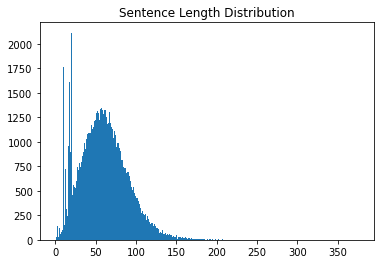

In [13]:
min_len = 999 # 절때 최소가 될 수 없는 수로 잡아준다 
max_len = 0
sum_len = 0

for sen in raw:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(raw))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in raw:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

\\


## 최대, 최소값 결과를 보고 생각할 수 있을 만한 것들? 
- 길이 1짜리 문장은 대체 무엇인가
- 0과 50 사이에 치솟는 부분은 무엇인가
- 어디서부터 어디까지 자를것인가!

### 1. 길이 1 짜리 문장은 대체 무엇인가..?

In [14]:
def check_sentence_with_length(raw, length):
		count = 0

		for sen in raw:
				if len(sen) == length:
						print(sen)
						count += 1
						if count > 100: return 

check_sentence_with_length(raw, 1)

’


* ’ 도 하나의 문장으로 쳤기 때문에 짧은 문장이라구 나온거구나.. 

### 2. 문장의 수가 1500을 초과하는 문장

In [15]:
for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 1500을 초과하는 문장 길이를 추출합니다.
    if _sum > 1500:
        print("Outlier Index:", idx+1)

Outlier Index: 11
Outlier Index: 19
Outlier Index: 21


In [16]:
#index 11 에 대한 문장을 출력 해 봅니다 
check_sentence_with_length(raw, 11)

라고 조던이 말했다.
- 모르고 있습니다.
- 네, 보이는군요.
디즈니사만이 아니다.
큰 파티는 아니지요.
의자는 비어 있었다.
이 일은 계속됩니다.
나는 크게 실망했다.
그 이유는 간단하다.
이력서와 자기 소개서
시대가 변하고 있다.
는 돌발질문을 했다.
9. 몇 분간의 명상
하와이, 빅 아일랜드
키스를 잘 하는 방법
키스를 잘 하는 방법
스피어스가 뚱뚱한가?
산 위를 나는 느낌.
세 시간쯤 걸었을까?
(아직 읽고있습니까?
처음에는 장난이었다.
우리는 운이 좋았다.
아기가 숨을 멈출 때
건물 전체 무너져내려
그녀의 아름다운 눈.
대답은 다음과 같다.
"사과할 것이 없다.
폭탄테러가 공포 유발
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1

- 중복.. 처리가.. 제대로 되지 않아서 글자수가 이렇게 길었던거였어..
- 중복 제거는 `set` 자료형을 활용합니다.
    - 집합을 정의하는 자료형
    - **중복을 허용하지 아니함 ⇒ 변환 과정에서 자동으로 중복된 요소를 제거해줌!!**
    - 주의 : list의 순서가 뒤바뀔 수 있음

Data Size: 77591
문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


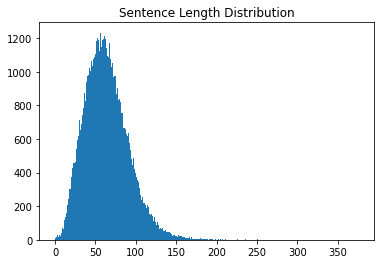

In [17]:
# 중복을 제거한 후, 앞에서 분포를 확인한 소스를 다시 실행시켜 봅니다. 
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

* 데이터가 17000개 가량 줄어들었다.  

\\


### 3. 모든 데이터를 다 사용할꺼야? 


- 후에 미니배치를 만들 것을 생각하면 연산 측면에선 비효율적!
    - 각 데이터의 크기가 모두 동일해야하기 때문에 가장 긴 데이터로 padding 처리를 해 줘야하기 때문에!
    - ex) 길이가 100 인 문장 까지만 사용할 경우
  - $[(77591 - 길이 100 초과 문장 수)\times 100]$
    - 데이터를 모두 사용할 경우
  - $[77591\times377]$
    
    ⇒ 전자보다 최소 3.7배 큰 메모리를 차지하게 됨. 학습시간이 늘어나는건 덤! 
    
- 길이별로 정렬해서 미니배치를 구성하는 방법으로 padding을 최소화 하는 방법도 있음.
    - But, 데이터를 섞는 데 편향성이 생길 수 있으므로 지양합시다! (안됨안됨 ㄴㄴㄴ)
- 길이 150 이상의 데이터를 제거하고 사용합니다. 
또한, 길이 10 미만의 데이터도 제거합니다.
    - 오히려 노이즈로 작용할 수 있기 때문에

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


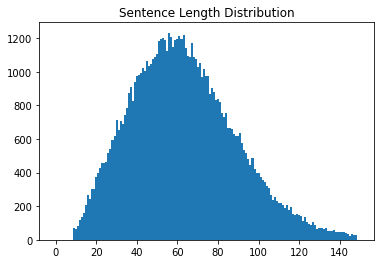

In [18]:
max_len = 150
min_len = 10

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

\\


-----

# 공백 기반 토큰화

- 먼저, 공백 기반 토큰화를 진행합니다.
- 정제된 데이터를 공백 기반으로 토큰화 하여 list에 저장한 후, 아래 `tokenize()` 함수를 사용해 단어 사전과 Tensor 데이터를 얻고, 단어 사전의 크기도 확인 해봅니다.

## 1. 공백기반 토큰화 하기! 

In [19]:
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [20]:
# 정제된 데이터를 공백 기반으로 토큰화하여 저장하는 코드를 직접 작성해봅니다. 
split_corpus = []

for kor in filtered_corpus:
    split_corpus.append(kor.split())

## 2. 단어사전 길이 확인해보기 

In [21]:
# 단어사전의 길이를 확인 해봅니다.
split_tensor, split_tokenizer = tokenize(split_corpus)

print('Split Vocab Size : ', len(split_tokenizer.index_word))

Split Vocab Size :  237435


* 생성된 단어 사전을 확인 해 볼까요?

In [22]:
for idx, word in enumerate(split_tokenizer.word_index):
    print(idx, ':', word)

    if idx > 10 : break

0 : 이
1 : 밝혔다.
2 : 있다.
3 : 말했다.
4 : 수
5 : 있는
6 : 그는
7 : 대한
8 : 위해
9 : 전했다.
10 : 지난
11 : 이번


## 3. 공백 기반 토큰화의 문제점?

- 밝혔다. 는 밝히다, 밝다 와 유사한 의미를 가지고 있음에도 전혀 다른 단어로 분류 되었을 것.
    1. 불필요하게 큰 단어사전을 가지게 됨 ⇒ **연산량 증가!** 
    2. `밝 + 혔다` 라고 토큰화 됬더라면..? ⇒ 학습 중에 의미 파악 하기가 수월 해 질 것.
    3. ⇒ 이때 필요한 것이 형태소 분석기다 이말이지

\\


-----


\\

# 형태소 기반 토큰화 


- 대표적인 한국어 형태소 분석기!
    - `Khaiii` , `KoNLPy`
- `KoNLPy` 중에서도 가장 성능이 우수한 `**MeCab` 클래스를 활용**합니다.
- 앞서 작성했던 코드를 활용해 MeCab 기반으로 생성된 단어 사전과 Tensor 데이터를 얻어봅니다.

## 1. MeCab 단어 사전 만들기 

In [23]:
# 위에서 사용한 코드를 활용해 MeCab 단어 사전을 만들어보세요. 
# Hint : mecab.morphs()를 사용해서 형태소분석을 합니다.

def mecab_split(sentence):
    return mecab.morphs(sentence)

mecab_corpus = []

for kor in filtered_corpus:
    mecab_corpus.append(mecab_split(kor))

* 형태소 기반 토큰화를 진행한 후, 단어 사전의 길이를 확인 해 봅니다. 

In [24]:
mecab_tensor, mecab_tokenizer = tokenize(mecab_corpus)

print('MeCab 단어장 사이즈 : ', len(mecab_tokenizer.index_word))

MeCab 단어장 사이즈 :  52279


\\
## 2. Tensor를 문장으로 Decoding


- tensor를 encoding 하는 과정을 거쳤으니, Decoding 해서 원문으로 돌려주는 작업도 필요합니다.
- `tokenizer.sequences_to_texts()` 함수를 사용하여 Decoding
- `tokenizer.index_word` 를 사용하여 Decoding
- 두 가지 방법으로 해 보겠습니다!


In [25]:
# Case 1 : tokenizer.sequences_to_texts()

texts = mecab_tokenizer.sequences_to_texts([mecab_tensor[100]])
print(texts[0])

“ 이번 발병 의 실체 를 파악 하 고 사태 를 진정 시키 기 위해 매우 적극 적 인 대응 노력 을 기울이 고 있 습니다 . ”


In [26]:
# Case 2 : tokenizer.index_word
sentence = ''

for w in mecab_tensor[100]:
    if w == 0: continue
    sentence += mecab_tokenizer.index_word[w] + ''

print(sentence)


“이번발병의실체를파악하고사태를진정시키기위해매우적극적인대응노력을기울이고있습니다.”




\\


----


\\

#  SentencePiece 모델 학습


```
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer
```

* `tf.keras.preprocessing.text.Tokenizer`에 `corpus`를 주고 `tokenizer.fit_on_texts(corpus)`을 하면 토크나이저 내부적으로 단어사전과 토크나이저 기능을 `corpus`에 맞춤형으로 자동 생성 해 주는 `tokenize` 함수를 만들었었습니다. 
* 위와 같은 과정을 해 주기 전에 SentencePiece 모델을 학습하는 과정을 거쳐야 한다... 라고 하네요? 
* 우선 예제에서 다뤄봤던 `korean-parallel-corpora` 데이터셋을 가져와 SentencePiece 모델을 학습시켜 보겠습니다. 


In [92]:
vocab_size = 8000

with open(path_to_file, 'w') as f:
    for row in filtered_corpus:
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(path_to_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.
# korean_spm* 안에 있는 -l 속성을 파일명과 함께 보는 코드 
!ls -l korean_spm*

-rw------- 1 root root 375145 Mar 23 10:14 korean_spm.model
-rw------- 1 root root 144504 Mar 23 10:14 korean_spm.vocab


* 위 코드를 실행하면 정상적으로 SentencePiece 모델 학습이 완료된 후 `korean_spm.model` 파일과 `korean_spm.vocab` vocabulary 파일이 생성되었음을 확인할 수 있습니다. 


* 그럼 이렇게 학습된 SentencePiece 모델을 어떻게 활용하는지 살펴보겠습니다.

In [93]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1661, 9, 463, 16, 1381, 9, 158, 15, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


\\


---


# Tokenizer 함수 작성 

* 위에서 훈련 시킨 SentencePiece를 활용하여 위 함수와 유사한 기능을 하는  `sp_tokenize()` 함수를 정의합니다.
* 정의 할 때, 아래 조건에 만족하는 함수를 정의합니다. 

> 조건!   
    1) 매개변수로 토큰화된 문장의 list를 전달하는 대신 온전한 문장의 list 를 전달합니다.  \\
    2) 생성된 vocab 파일을 읽어와 { <word> : <idx> } 형태를 가지는 word_index 사전과 { <idx> : <word>} 형태를 가지는 index_word 사전을 생성하고 함께 반환합니다.  \\
    3) 리턴값인 tensor 는 앞의 함수와 동일하게 토큰화한 후 Encoding된 문장입니다. 바로 학습에 사용할 수 있게 Padding은 당연히 해야겠죠?


In [94]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [95]:
#sp_tokenize(s, corpus) 사용예제

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(tensor)

[[ 515 3257   14 1097 2572    4    0    0    0]
 [1597 2169  228  544    9  280 7922  756    8]]


\\


---- 

# 네이버 영화리뷰 감정 분석 문제에 SentencePiece 적용해 보기


\\
* [네이버 영화리뷰 감정 분석 태스크](https://github.com/e9t/nsmc/)가 있습니다. 한국어로 된 corpus를 다루어야 하므로 주로 KoNLPy에서 제공하는 형태소 분석기를 사용하여 텍스트를 전처리해서 RNN 모델을 분류기로 사용하게 되는데요 ,  
만약 이 문제에서 tokenizer를 SentencePiece로 바꾸어 다시 풀어본다면 더 성능이 좋아질까요? 비교해 보는 것도 흥미로울 것입니다. 


* 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기
* 학습된 모델로 sp_tokenize() 메소드 구현하기
* 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기
* KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
* (보너스) SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

## &nbsp;&nbsp; 4-1 네이버 영화리뷰 감정 분석 태스크 불러오기 


* exp6 에서 사용해 봤던, 네이버 영화 리뷰 감정 분석 태스크를 가져오겠습니다. 


In [31]:
# train 데이터 가져오기

urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")

('ratings_train.txt', <http.client.HTTPMessage at 0x7fced7050290>)

In [32]:
# test 데이터 가져오기

urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7fced602a5d0>)

In [33]:
train_data = pd.read_csv('ratings_train.txt', sep= '\t', engine='python', encoding='utf-8')
test_data = pd.read_csv('ratings_test.txt', sep= '\t', engine='python', encoding='utf-8')

In [34]:
train_data.head(5)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [35]:
test_data.tail(5)

,id,document,label
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0
49999,6070594,마무리는 또 왜이래,0




* 불러온 데이터를 확인 해 보고, 한꺼번에 필요한 처리를 해 주기 위해 train data와 test data를 합쳐줍니다. 


In [101]:
data = pd.concat([train_data, test_data], ignore_index=True)
data

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
199995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
199996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
199997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
199998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


* 불필요한 column을 삭제합니다. 이번 프로젝트에선 리뷰부분인 `document` 부분만 남기겠습니다. 

In [102]:
data = data.drop(['id', 'label'], axis = 1)
data

,document
0,아 더빙.. 진짜 짜증나네요 목소리
1,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
2,너무재밓었다그래서보는것을추천한다
3,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
4,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...
...,...
199995,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함
199996,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO
199997,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다
199998,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네


## &nbsp;&nbsp; 4-2 데이터 살펴보기 

* 중복 데이터를 확인 해 보고, 중복 샘플을 제거합니다. 
* null 값도 확인 해볼까요?
* 각 문장의 길이를 알아봅니다. 최단길이, 최장길이, 평균 길이를 구한 후, 문장 길이 분포를 막대그래프로도 표현 해봅시다. 
* 문제가 되는 부분이 있다면 제거 해 봅시다 :) 

In [103]:
print('document 열에서 중복을 배제한 유일한 샘플의 수 :', data['document'].nunique())

document 열에서 중복을 배제한 유일한 샘플의 수 : 194543


In [104]:
# null값도 확인 해 볼게요!
print('Null값도 있나 확인 해봤어요! 그랬더니! ->', data.isnull().sum())

Null값도 있나 확인 해봤어요! 그랬더니! -> document    8
dtype: int64


* 중복된 부분이 약 6000개 가량 있는걸 확인 할 수 있었다.
* 빈 데이터도 8부분이나 있었다. 
* 중복 샘플과 Null 값을 제거해 주겠습니다!


In [105]:
# 중복 샘플 제거하기 
# inplace=True를 설정하면 DataFrame 타입 값을 return하지 않고 data 내부를 직접적으로 바꿈.
data.drop_duplicates(subset = ['document'], inplace=True)
print('전체 샘플수:', (len(data)))


전체 샘플수: 194544


In [106]:
# null 샘플 제거
data.dropna(axis = 0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 194543


## &nbsp;&nbsp; 4-3 데이터 전처리 하기.


* 가져온 데이터를 전처리 합니다. 전처리 과정은 지금까지 진행한 익스들의 전처리 과정을 확인 해보고, 적용해 보겠습니다. 이번 프로젝트에서 진행 해 볼건,  sentencepiece를 적용해 보는것 이기 때문에 잘 분류를 할 수 있게끔 해주면 될것같다. 

* 시작하기에 앞서, 가져온 데이터셋의 특징을 살펴보고, 전처리 했으면 좋겠다 싶은 부분을 정리 해보는 작업을 가지겠습니다.

* 그 다음, 위에서 파악한 부분을 토대로 데이터를 전처리 해 주겠습니다.

* 4-2 에서 알아봤던 너무 긴 문장도 추려주겠습니다. 



### 전처리 해 볼만한 부분?

1. 특수문자 제거 
    - `!`, `.` 같은 자주 쓰이는 문장부호
    - `^^`, `-` 등등  감정 표현등에 사용했을 법 한 특수문자

2. 자음, 모음으로만 이루어진 문자들 
    - `ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ`,`ㅠㅠㅠㅠㅠ`, `ㅎㅎㅎ`

3. 오타로 간주될 것 같은 영어문자, 단어 들 
* 한국어를 분류해 볼 것이기 때문에, 영어로 이루어진 문자, 잘못 기입했을 법한 알파벳들도 없애줍니다. 


In [177]:
# 전처리 함수
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

  # 한글로 이루어진 단어를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^가-힣\d]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

print("전처리 함수가 만들어졌어요!")

preprocess_sentence('우리집 ㅠㅠㅠㅠ oh 오늘 ㅇexp..,. ㄷ..ㄷㄷ.. ..\[].. 대박쓰; ')

전처리 함수가 만들어졌어요!


'우리집 오늘 대박쓰'

In [178]:
print(raw.count())

194543


In [179]:
# for문을 돌려주기 위해 index 초기화 
raw = raw.reset_index(drop=True)

In [180]:
# 문제가 됬던 부분 확인 
raw[1058]

'기분 완전 상콤해지는데? ㅋ'

In [181]:
# 전처리 함수 영화 리뷰 데이터에 적용하기 
# preprocess_sentence(raw[1])
changed_sentence = []

for i in range(194543):
    chge = preprocess_sentence(raw[i])
    changed_sentence.append(chge)


In [182]:
changed_sentence[0]

'아 더빙 진짜 짜증나네요 목소리'

## 긴 문장, 짧은 문장 cut! 


* 가장 긴 데이터로 padding 처리가 들어가기 때문에, 60이상의 너무 긴 문장은 제거 해줍니다.
* 3 미만의 짧은 문장도, 오히려 노이즈로 작용될 수 있기 때문에 삭제합니다. 


* 리뷰 문장의 최대 길이, 최소길이 등을 알아보겠습니다. 
* 막대 그래프로 시각화해서 확인 해 보겠습니다.

In [195]:
min_len = 999
max_len = 0
sum_len = 0

for sen in changed_sentence:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(raw))

# sentence_length = np.zeros((max_len), dtype=np.int)

# for sen in raw:
#     sentence_length[len(sen)-1] += 1

# plt.bar(range(max_len), sentence_length, width=1.0)
# plt.title("Sentence Length Distribution")
# plt.show()

문장의 최단 길이: 0
문장의 최장 길이: 140
문장의 평균 길이: 33


\\


## 최단길이, 최장길이 등을 보고 확인 해 볼 만한 것들 

- 길이 1짜리 문장은 대체 무엇인가
- 0과 50 사이에 치솟는 부분은 무엇인가
- 어디서부터 어디까지 자를것인가!

### 길이 1 짜리 문장 확인 해 보기 

In [192]:
def check_sentence_with_length(raw, length):
		count = 0

		for sen in raw:
				if len(sen) == length:
						print(sen)
						count += 1
						if count > 100: return 

check_sentence_with_length(changed_sentence, 1)

아
잼
즐
끙
1
4
와
굿
굿
기
짱
휴
야
음
즐
바
즐
굳
아
하
네
굿
굿
굿
굿
음
짱
우
쒯
0
굿
아
쩝
토
아
즐
굿
똥
굿
아
굿
흠
하
앜
류
헐
쩝
굿
삼
풉
꽝
음
음
굳
굳
굿
아
풉
오
아
왜
쉣
좇
봐
굿
까
뿌
짱
하
굳
참
0
굿
가
잼
음
굿
굳
흥
7
음
2
찜
굿
올
흠
기
귯
린
아
후
쨩
흠
시
굿
짱
짱
왜
기
흠
굿


2. 문장의 길이가 3000을 초과하는 문장은? 

In [196]:
for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 3000을 초과하는 문장 길이를 추출합니다.
    if _sum > 3000:
        print("Outlier Index:", idx+1)

In [197]:
#index 11 에 대한 문장을 출력 해 봅니다 
check_sentence_with_length(changed_sentence, 11)


아햏햏 아햏햏 아햏햏
용가리 진짜짱짱맨이다
무술인이 왜 총을드나
내 생의 최고의 영화
현실은 꿈 꿈은 현실
아진짜너무좋아요 짱짱
이적의 소설 재미없다
그냥 레전드다 레전드
이딴게 한국 영화라니
짜가인가 이게뭐여 뭔
번지수 잃고 갈팡질팡
역시 명작은 명작이다
너무나 감동적인 영화
안타까울뿐 안타까울뿐
드릴브라 에서 뿜었다
내 인생 최고의 영화
감독 다신영화찍지마라
이런 영화가 참 좋다
커스틴 때문에 좋겠다
재미있게봄 감동적이고
딱 90년대코미디영화
정말 광해와 비슷한가
잠을 청할 수 있었다
내 인생 최고의 미드
파란색 슬픔이 영화에
내사랑 키아누 리브스
기적은 이미 일어났다
답을 알려고 하지마라
야경꾼보다 엉망지루함
자식을 그렇게 때리냐
딱말해준다잉 안나온다
가슴이 뭉클 아름답딘
장선우 여전히 쓰레기
한국영화흥행의 시작점
이런건 보는거 아니야
시대착오적 애니메이션
우아하다는 말에 공감
실력이 필요없는 상황
감동과 웃음을 한방에
난 이거 되게 재밌네
명작인데 왜들 이러지
거 참 재밌는 영화균
어른이 보기에도 잼남
시간가는줄모르고 봤다
그냥 보통으로 보았다
뷰우우우우티이이이이풀
개꿀잼 개꿀잼 10자
재밌어요 나름 괜찮음
유치해 너무 재미없어
그냥 쓰레기지 쓰레기
별로에요 재미없네요호
이거 뭐지 이거 영화
이건무슨 내용이 없어
어색한 연기 어쩔거야
이제보니까 장백기였네
어차피 우승은 송민호
어이없어 그저 웃지요
이상형이 바뀌었습니다
화가 난다 화가 난다
역시 산드라블록 누님
결국 엄마가 죽인거네
대역이 더 맘에 드넹
원주율 좀 만들어보자
그녀의 용기에 박수룰
얍얍 콩 나와라 뚝딱
우연이 만들어낸 사랑
나도 다큐나 찍어볼까
마지막에어이없네왜죽어
이건 정말 명작이네요
역시 명작 최고입니다
좀더 재미있게 만들면
별덤높이기다디다디도러
무조건 봐야되여 강추
간만에쓰레기영화보네요
정말 현실성없는 영화
가 죽임 스케일도크고
어린아이들만 재미있고
그렇게 대단하지 않다
견자단 액션 너무좋음
좋은 프로 감사합니다
짱 오늘 티비로 봤음
아무리 저예산이라지만
내용을말로표현못하게씀
성룡영화

* 중복 보다는 다른 리뷰가 한데 짬뽕되어 버린것 같다... 아님 저렇게 길게 적었을리가..

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


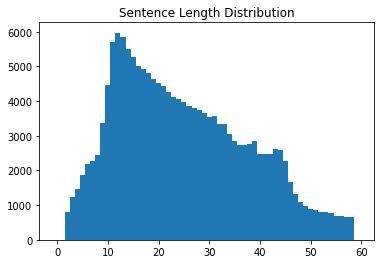

In [198]:
max_len = 60
min_len = 3

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()




---





\\


# SentencePiece를 적용시킨 모델을 네이버 감정분석 코퍼스에 적용 해 보기!  

* 적용 해 보기 위해선, 위에서 정제된 문장들의 type가 str이 되야 합니다. 


In [188]:
print(type(changed_sentence))

<class 'list'>


In [ ]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

In [189]:
def sentence_piece_here(row) :
    # SentencePiece를 활용한 sentence -> encoding
    tokensIDs = s.EncodeAsIds(row)
    print(tokensIDs)

    # SentencePiece를 활용한 sentence -> encoded pieces
    print(s.SampleEncodeAsPieces(row,1, 0.0))

    # SentencePiece를 활용한 encoding -> sentence 복원
    print(s.DecodeIds(tokensIDs))


In [190]:
sentence_piece_here(changed_sentence[1])

[1414, 1210, 166, 1401, 31, 243, 2842, 340, 1519, 4460, 19, 684, 437]
['▁흠', '▁포스터', '보고', '▁초딩', '영화', '줄', '▁오버', '연기', '조차', '▁가볍', '지', '▁않', '구나']
흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나


----


# 이번에도 돌아왔습니다! 갑자기 분위기 회고~~(안기쁨) 


* 책상 한켠에 적어둔 글귀가 있다. 

###`겁먹지 말고 일단 해 보자. 해 보면 분명 재밌을 것이다.`

* 프로젝트를 시작하기 전 까진 어떻게 해야할지 막막하고, 어떻게 하면 좋을 지 생각만 하다가 결국 실천을 하지 못하였다.결국 마지막 날 되서 본격적으로 하게 됬는데, 하다보니 네이버 데이터를 가져와 합치고, 필요없는 셀을 지우고, 텍스트 데이터를 전처리하는 과정이 너무 재밌었다. 전처리 해 보는것도, txt 형식 파일을 dataframe으로 만들었다가, str 형태 데이터로 추출하는것 등등, 처음엔 막막하다고만 생각했던 것 들인데, 막상 시작해 보니 재밌었다:) 적어 놓은 글귀 처럼, 일단 시작하니 과정이 점점 재밌어졌다. 분명 여태까지 익스를 진행 하면서 느꼈을 부분이였을텐데..  다음 프로젝트부턴 다양하게 시도 해보고 자신을 가지고, 꼭 엄청 잘 해야한단 생각을 내려놓고, 조금만 잘 하면서 재밌게 해 보도록 노력 해 봐야지:D 

* 

-----
\\

# 🖇 참고 페이지 


## 데이터 불러오기 
* [네이버 영화 리뷰 감정 분류 wikidocs](https://wikidocs.net/44249)


## 네이버 영화 데이터 전처리 및 확인
* exp 8. 뉴스 요약봇 만들기 